In [23]:
%matplotlib inline
from utility import *

# Models

In this section, we'll use the features we created in the previous section, along with IDF-weighted embeddings and try them on different models. 

As mentioned earlier, when dealing with small datasets, low-complexity models like Logistic Regression, SVMs and Naive Bayes will generalize the best. We'll try these models along with non-parameteric models like KNN and non-linear models like Random Forest, XGBoost etc. 

We'll also try bootstrap-aggregating or bagging with the best-performing classifier along with stacking using VotingClassifer. Let's get started!

In [24]:
from featurization import *
import pandas as pd 
import numpy as np

EMB='bert'

In [25]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')
label_list= sorted(list(set(test.label.values)))
lbl_to_idx = {item:i for i,item in enumerate(label_list)}
idx_to_lbl = {i:item for i,item in enumerate(label_list)}
print(lbl_to_idx)
print(idx_to_lbl)
y_train = train.label
y_test = test.label
print(y_train.shape)
print(y_test.shape)
len(set(y_train.values))
train_features = np.genfromtxt("../datasets/train_feature_infersent.csv", delimiter=",")
test_features = np.genfromtxt("../datasets/test_feature_infersent.csv",delimiter=",")
print(train_features.shape)
print(test_features.shape)

{0: 0, 2: 1, 5: 2, 6: 3, 8: 4, 11: 5, 13: 6, 14: 7, 15: 8, 16: 9, 18: 10, 19: 11, 21: 12, 27: 13, 28: 14, 39: 15, 46: 16, 50: 17, 53: 18}
{0: 0, 1: 2, 2: 5, 3: 6, 4: 8, 5: 11, 6: 13, 7: 14, 8: 15, 9: 16, 10: 18, 11: 19, 12: 21, 13: 27, 14: 28, 15: 39, 16: 46, 17: 50, 18: 53}
(93,)
(79,)
(93, 4096)
(79, 4096)


GridSearchCV HelperFunction

In [26]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer, accuracy_score
from scipy import sparse


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


def adjusted_f1(y_true, y_prob):
    f1 = print_model_metrics(y_true, y_prob, verbose = 0, return_metrics = True)
    return f1

score = make_scorer(adjusted_f1, greater_is_better = True, needs_proba = True)



# Since we want to use a predefined Test/Val set, we'll use PredefinedSplit and pass it as the CV parameter
# We need to merge both the datasets and label 0 for test and -1 for the train set


def run_grid_search(model, params, x_train, y_train):
    grid = GridSearchCV(model, params, cv = 3, n_jobs = -1, scoring = score, verbose = 0, refit = False)
    grid.fit(x_train, y_train)
    return (grid.best_params_, grid.best_score_)

In [27]:
# Run log reg n times and average the metrics
def fit_n_times(model, x_train, y_train, x_test, y_test, label_list, n_iters = 10):
    model.fit(x_train, y_train)
    y_test_prob = model.predict_proba(x_test)
    y_pred = model.predict(x_test)
    print("roc")
    print(roc_auc_score(y_test,y_test_prob,labels = label_list,multi_class='ovr',average="weighted"))
    print("f1")
    print(f1_score(y_test,y_pred,labels=label_list,average="weighted"))
    print("acc")
    print(accuracy_score(y_test,y_pred))

## SVM

In [29]:
from sklearn.svm import SVC

svm = SVC(probability = True)
#svm_params = {'C' : [10**(x) for x in range(-1,4)],
#             'kernel' : ['poly', 'rbf', 'linear'],
#             'degree' : [2, 3]}
#clf = GridSearchCV(svm, svm_params)
#clf.fit(train_features, y_train)
#best_params, best_f1 = clf.best_params_, clf.best_score_

#print('Best Parameters : {}'.format(best_params))
#print('Best F1 : {}'.format(best_f1))
best_params = {'C': 10, 'degree': 2, 'kernel': 'poly'}
svm = SVC(C = best_params['C'], kernel = best_params['kernel'], degree = best_params['degree'], probability = True)
fit_n_times(svm, train_features, y_train, test_features, y_test, label_list)

roc
0.9659735780573941
f1
0.6952959487769614
acc
0.6962025316455697


## Naive Bayes

In [30]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(class_prior = [0.5, 0.5])

print('Best Parameters : {}'.format(best_params))
print('Best F1 : {}'.format(best_f1))

nb = MultinomialNB(alpha = best_params['alpha'])

fit_n_times(nb, train_features, y_train, test_features, y_test)
# Negative values in data passed to MultinomialNB (input X)

## Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs = -1)

print('Best Parameters : {}'.format(best_params))
rf = RandomForestClassifier(n_estimators = best_params['n_estimators'],
                            min_samples_split = best_params['min_samples_split'],
                            max_depth = best_params['max_depth'], 
                            n_jobs = -1)
fit_n_times(rf, train_features, y_train, test_features, y_test,label_list)

Best Parameters : {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 500}
roc
0.9800551863774555
f1
0.7366120203090958
acc
0.759493670886076


## XGBoost

In [32]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs = -1)

xgb_params = { 'n_estimators' : [10, 100, 200, 500], 
               'max_depth' : [1, 2, 3, 7],
               'learning_rate' : [0.1, 0.2, 0.01, 0.3],
               'reg_alpha' : [0, 0.1, 0.2]
}
y_train = [lbl_to_idx[item] for item in y_train]
y_test = [lbl_to_idx[item] for item in y_test]
label_list = [lbl_to_idx[item] for item in label_list]
print(len(set(y_train)),len(set(y_test)))
#clf = GridSearchCV(xgb, xgb_params)
#clf.fit(train_features, y_train)
#best_params, best_f1 = clf.best_params_, clf.best_score_
best_params= {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 100, 'reg_alpha': 0.1}

print('Best Parameters : {}'.format(best_params))
xgb = XGBClassifier(n_estimators = best_params['n_estimators'],
                            learning_rate = best_params['learning_rate'],
                            max_depth = best_params['max_depth'], 
                            reg_alpha = best_params['reg_alpha'], 
                            n_jobs = -1)
fit_n_times(xgb, train_features, y_train, test_features, y_test,label_list)

label_list = [idx_to_lbl[item] for item in label_list]
y_train = np.asarray(y_train).astype('float32').reshape((-1,1)).ravel()
y_test = np.asarray(y_test).astype('float32').reshape((-1,1)).ravel()
print(y_train.ravel().shape)

print(y_test.shape)
print(train_features.shape)
print(test_features.shape)

19 19
Best Parameters : {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 100, 'reg_alpha': 0.1}
roc
0.9532990180542041
f1
0.7199935086011036
acc
0.759493670886076
(93,)
(79,)
(93, 4096)
(79, 4096)


## DL Tabular Data

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import SparseCategoricalCrossentropy
loss_fn = SparseCategoricalCrossentropy(from_logits=True)
batch_size = 128
epochs = 40

simple_nn = Sequential()
simple_nn.add(Flatten(input_shape=(4096,)))
simple_nn.add(Dense(100, activation='relu'))
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(19, activation='softmax'))

simple_nn.summary()

simple_nn.compile(loss=loss_fn,
              optimizer=Adam(),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('./saved_models', monitor = 'val_accuracy', verbose = 1, save_best_only=True)
history = simple_nn.fit(train_features,y_train, epochs=epochs)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 100)               409700    
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 19)                1919      
                                                                 
Total params: 411,619
Trainable params: 411,619
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
3/3 [==============================] - 0s 3ms/step - loss: 2.9172 - accuracy: 0.1075
Epoch 2/40
3/3 [==============================] - 0s 4ms/step - loss: 2.7441 - accur

In [34]:
simple_nn.evaluate(test_features,y_test,verbose=2)


3/3 - 0s - loss: 0.8806 - accuracy: 0.7468 - 79ms/epoch - 26ms/step


[0.8805742859840393, 0.746835470199585]

In [35]:
from tensorflow.keras.models import load_model

simple_nn = load_model('./saved_models')

In [36]:
simple_nn.evaluate(test_features,y_test,verbose=2)
y_pred_prob = simple_nn.predict(test_features)
print_model_metrics(y_test, y_pred_prob)
y_train = [idx_to_lbl[item] for item in y_train]
y_test = [idx_to_lbl[item] for item in y_test]

ValueError: in user code:

    File "/Users/heejinchae/opt/anaconda3/envs/smallData/lib/python3.9/site-packages/keras/engine/training.py", line 1366, in test_function  *
        return step_function(self, iterator)
    File "/Users/heejinchae/opt/anaconda3/envs/smallData/lib/python3.9/site-packages/keras/engine/training.py", line 1356, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/heejinchae/opt/anaconda3/envs/smallData/lib/python3.9/site-packages/keras/engine/training.py", line 1349, in run_step  **
        outputs = model.test_step(data)
    File "/Users/heejinchae/opt/anaconda3/envs/smallData/lib/python3.9/site-packages/keras/engine/training.py", line 1303, in test_step
        y_pred = self(x, training=False)
    File "/Users/heejinchae/opt/anaconda3/envs/smallData/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/heejinchae/opt/anaconda3/envs/smallData/lib/python3.9/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 119), found shape=(None, 4096)


# Bagging

Since SVM worked so well, we can try a bagging classifier by using SVM as a base estimator. This should improve the variance of the base model and reduce overfitting. 

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

svm = SVC(C = 10, kernel = 'poly', degree = 2, probability = True, verbose = 0)

svm_bag = BaggingClassifier(svm, n_estimators = 200, max_features = 0.9, max_samples = 1.0, bootstrap_features = False, bootstrap = True, n_jobs = 1, verbose = 0)

svm_bag.fit(train_features, y_train)
y_test_prob = svm_bag.predict_proba(test_features)[:,1]
print_model_metrics(y_test, y_test_prob)

F1: 0.964 | Pr: 0.955 | Re: 0.972 | AUC: 0.993 | Accuracy: 0.963 



# Stacking Classifier

Finally, one last thing we can try is the Stacking Classifier = basically a weighted average of the predictions of different models. Since we are using the fast ai tabular learner we wont be able to use Sklearn's `VotingClassifier` instead we'll just run a simple loop that gets the predictions of each model and runs a weighted average. 

In [ ]:
# Define all models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss = 'log', alpha = 0.1, penalty = 'elasticnet')
svm = SVC(C = 10, kernel = 'poly', degree = 2, probability = True)
nb = MultinomialNB(alpha = 10000, class_prior = [0.5, 0.5])
knn = KNeighborsClassifier(n_neighbors = 7, weights = 'distance', n_jobs = -1)
rf = RandomForestClassifier(n_estimators = 250, min_samples_split = 5, max_depth = 15,  n_jobs = -1)
xgb = XGBClassifier(n_estimators = 100, learning_rate = 0.3, max_depth = 1, n_jobs = -1)

model_dict = dict(zip(['LR', 'SVM', 'NB', 'KNN', 'RF', 'XGB'], [lr, svm, nb, knn, rf, xgb]))

for model_name, model in model_dict.items():
    print('Training {}'.format(model_name))
    model.fit(train_features, y_train)

model_weights = {   'LR' : 0.9,
                    'SVM' : 0.9,
                    'NB' : 0.8,
                    'KNN' : 0.75,
                    'RF' : 0.75,
                    'XGB' : 0.6,
                    'simple_nn' : 0.7
}

y_pred_prob = 0

for model_name, model in model_dict.items():
    y_pred_prob += (model.predict_proba(test_features)[:,1] * model_weights[model_name])

y_pred_prob += (simple_nn.predict(test_features.todense()).ravel() * model_weights['simple_nn'])
y_pred_prob /= sum(model_weights.values())

print_model_metrics(y_test, y_pred_prob)

Training LR
Training SVM
Training NB
Training KNN
Training RF
Training XGB
F1: 0.968 | Pr: 0.959 | Re: 0.977 | AUC: 0.995 | Accuracy: 0.967 



In [ ]:
def run_voting_clf(model_weights):
    #result_list, model_weights = data
    
    y_pred_prob = 0

    for model_name, model in model_dict.items():
        y_pred_prob += (model.predict_proba(test_features)[:,1] * model_weights[model_name])

    #y_pred_prob += (simple_nn.get_preds(ds_type = DatasetType.Valid)[0].numpy()[:,0] * model_weights['simple_nn'])
    y_pred_prob += (simple_nn.predict(test_features.todense()).ravel() * model_weights['simple_nn'])
    y_pred_prob /= sum(model_weights.values())
    f1 = print_model_metrics(y_test, y_pred_prob, return_metrics = True, verbose = 0)[0]
    return {'loss' : -f1, 'status' : STATUS_OK}

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

trials = Trials()
model_weights = fmin(run_voting_clf,
    space= {
        'LR' : hp.uniform('LR', 0, 1),
        'SVM' : hp.uniform('SVM', 0, 1),
        'NB' : hp.uniform('NB', 0, 1),
        'KNN' : hp.uniform('KNN', 0, 1),
        'RF' : hp.uniform('RF', 0, 1),
        'XGB' : hp.uniform('XGB', 0, 1),
        'simple_nn' : hp.uniform('simple_nn', 0, 1),


    },
    algo=tpe.suggest,
    max_evals=500,
    trials = trials)

100%|██████████| 500/500 [03:27<00:00,  2.41trial/s, best loss: -0.9725631048588247]


In [ ]:
model_weights = {'KNN': 0.7866810233035141,
 'LR': 0.8036572275670447,
 'NB': 0.9102009774357307,
 'RF': 0.1559824350958057,
 'SVM': 0.9355079606348642,
 'XGB': 0.33469066125332436,
 'simple_nn': 0.000545264707939086}

F1: 0.968 | Pr: 0.960 | Re: 0.977 | AUC: 0.995 | Accuracy: 0.968 



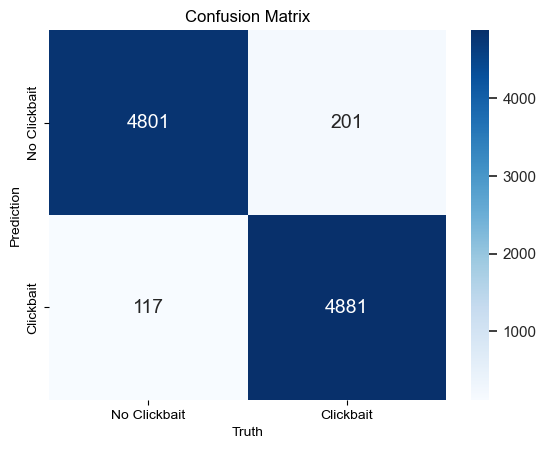

In [ ]:
y_pred_prob = 0
for model_name, model in model_dict.items():
    y_pred_prob += (model.predict_proba(test_features)[:,1] * model_weights[model_name])

y_pred_prob += (simple_nn.predict(test_features.todense()).ravel() * model_weights['simple_nn'])
y_pred_prob /= sum(model_weights.values())
print_model_metrics(y_test, y_pred_prob, confusion = True)

In [ ]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred_prob, pos_label = 1)
    
#Find the threshold value that gives the best F1 Score
best_f1_index =np.argmax([calc_f1(p_r) for p_r in zip(precision, recall)])
best_threshold, best_precision, best_recall = threshold[best_f1_index], precision[best_f1_index], recall[best_f1_index]

# Calulcate predictions based on the threshold value
y_test_pred = np.where(y_test_prob > best_threshold, 1, 0)

In [ ]:
misclassified_idx = y_test != y_test_pred
high_confidence_indices = np.argsort(y_test_prob[misclassified_idx])[-10:]

In [ ]:
for idx in high_confidence_indices:
    print('Title : {}'.format(test[misclassified_idx].title.values[idx]))
    print('Label : {}'.format(test[misclassified_idx].label.values[idx]))
    print('Predicted Probability : {}'.format(y_test_prob[misclassified_idx][idx]))
    print('-' * 10)

Title : A Putter That Provides Digital Instruction
Label : not-clickbait
Predicted Probability : 0.8632326356556083
----------
Title : The Cowboys Win a Wild One
Label : not-clickbait
Predicted Probability : 0.8791116327950125
----------
Title : Private Jets Lose That Feel-Good Factor
Label : not-clickbait
Predicted Probability : 0.8967078060487989
----------
Title : Male models win The Amazing Race
Label : not-clickbait
Predicted Probability : 0.8976823119079569
----------
Title : A Little Rugby With Your Cross-Dressing?
Label : not-clickbait
Predicted Probability : 0.90716076302164
----------
Title : Cellphone Abilities That Go Untapped
Label : not-clickbait
Predicted Probability : 0.9116531752723185
----------
Title : Darwinism Must Die So That Evolution May Live
Label : not-clickbait
Predicted Probability : 0.9138236285753103
----------
Title : Woods Returns as He Left: A Winner
Label : not-clickbait
Predicted Probability : 0.9141662468603614
----------
Title : A Peaking Tiger Wood

In [ ]:
test[test.label.values == 'not-clickbait'].sample(10).title.values

array(['A.I.G. Balks at Claims From US Airways Jet Ditched in Hudson',
       'Avery, With Wolf Pack, Is Grateful to Be Playing Hockey Again',
       'Red Sox Lose Another Road Game',
       'ICC prosecutor seeks arrest of Sudanese president',
       'Pelfrey and Mets Take Advantage of Sloppy Nationals',
       'WMAQ reporter Amy Jacobson leaves job following controversial video',
       'False dawn for Air France flight; debris not from crash, search continues',
       'Severe storm hits United Kingdom in the early morning',
       'An Unexpected Increase in Factory Orders',
       "Apaches accuse Prescott Bush of robbing Geronimo's grave"],
      dtype=object)